# Community Housing survey Project (CHP) EDA
This notebook is designed to do exploratory data analysis (EDA) for the 2020 PhD-Community Initiative Housing
Survey dataset

Coded by Josh Moskowitz in February 2020

---




Import the relevant libraries and other setup

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup
%matplotlib inline
pd.set_option('display.max_columns', None)

Import survey data

In [23]:
survey = pd.read_excel('F:/Users/Josh/Dropbox/PhD-CI/KCH_01312020_70.xlsx',index_col=None,header=0)
# survey = pd.read_excel('C:/Users/Josh/Desktop/Dropbox/PhD-CI/KCH_01312020_70.xlsx',index_col=None,header=0)
questions = survey.iloc[0][:] # grab question wording and store for later

## Cleanup survey data

Remove unecessary rows and cols

In [24]:
survey.drop(index=[0,1],inplace=True) # remove first 2 rows
# Remove any irrelevant or personally idenitifying columns
survey.drop(labels=['Status','IPAddress','RecipientLastName','RecipientFirstName','RecipientEmail',
                    'ExternalReference','LocationLatitude','LocationLongitude','DistributionChannel',
                    'UserLanguage','info','consent'],axis=1,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

Remove Whitespace and weird characters

In [25]:
def cleanDataFrame(obj):
    "Return a modified string"
    if isinstance(obj, str): # if object is a string
        return obj.replace("â€™", "'").strip() # fix apostrophes and remove trailing whitespace
    else:
        return obj

survey = survey.applymap(cleanDataFrame)

Function that will strip commas and split string when a person gave multiple responses

In [26]:
def cleanAndSplit(string):
    "Return a list of strings split by comma"
    
    # remove commas from one of the possible survey responses
    # "I need to be closer to work, childcare, or social/health support services"
    if "I need to be closer to work" in string:
        idx1 = string.find("childcare") - 2
        idx2 = string.find(" or ") - 1
        cleanString = string[:idx1] + string[idx1:idx2].replace(',','') + string[idx2+1:]
    else:
        cleanString = string

    return cleanString.split(',')

Function that will recode the employment column to only include one employment type

In [27]:
def recodeEmploy(row):
    "Return a Pandas row object with modified employment data"
    
    if isinstance(row.employment,str):
        listStatus = cleanAndSplit(row.employment)
        # we don't care if students are employed or not
        if 'Student' in listStatus:
            row.employment = 'Student'
        # we don't care if retirees are employed or not
        elif 'Retired' in listStatus:
            row.employment = 'Retired'
        else:
            row.employment = listStatus[0]
    return row
survey = survey.apply(recodeEmploy,axis='columns')

# Helper functions

In [28]:
def SepResp(col):
    "Return a Pandas series containing all strings present across this col"
    lst = []
    for i in col:
        if isinstance(i,str):
            lst.append(cleanAndSplit(i)) # Append responses to List

    lst = [item for sublist in lst for item in sublist] # flatten list
    return pd.Series(lst,index=None) # convert to series

This function will automatically generate plotting of response frequency or percentage for desired cols, with the option to group by a second variable

In [166]:
def plotResp(col,questions,order=None,normalize=False,title=None):
    "Creates a horizontal bar graph showing responses for this col"
    if title != None:
        title = title
    elif "Selected Choice" in questions[col.name]:
        title = questions[col.name][0:-17] # remove this extra text
    else:
        title = questions[col.name]
    if 'why_move' in col.name:
        col = SepResp(col)
    ax = col.value_counts(normalize=normalize).reindex(order).plot(kind='barh',title=title)
    if normalize:
        plt.draw()
        ax.set_xlabel('Percentage (%)')
        labels = ax.get_xticklabels() # Get locations and labels
        labels = [round(float(label.get_text())*100) for label in labels] # convert to int
        ax.set_xticklabels(labels)
    else:
        ax.set_xlabel('Count')
    if normalize:
        print(col.value_counts(normalize=normalize).reindex(order)*100)
    else:
        print(col.value_counts(normalize=normalize).reindex(order)) 
    return ax

In [89]:
def plotGroupBy(survey,col,groupBy,title,order=None,normalize=False):
    "Creates a horizontal bar graph showing grouped responses for this col by the groupBy variable"
    # Group by subsidy, convert to dataframe, and rename data col
    data = survey.groupby([groupBy])[col].value_counts(
        normalize=normalize).to_frame().rename(columns={col:'resp'})
    ax = pd.pivot_table(data, index = col, columns = groupBy, 
        values = 'resp').reindex(order).plot(kind = 'barh',title=title)       
    if normalize:
        plt.draw()
        ax.set_xlabel('Percentage (%)')
        labels = ax.get_xticklabels() # Get locations and labels
        labels = [round(float(label.get_text())*100) for label in labels] # convert to int
        ax.set_xticklabels(labels)
    else:
        ax.set_xlabel('Count')
    print(pd.pivot_table(data, index = col, columns = groupBy, 
        values = 'resp').reindex(order)*100)

In [254]:
def plotGroupByWhyMove(survey,groupBy,whyMoveNames,groupByNames,title,transpose=False,legendXLoc=2.2):
    
    # Create dataframe and get a prop for each category
    df_forStacked = pd.DataFrame(data=None,index=whyMoveNames,columns=None)
    
    groupByCounts = survey[groupBy].value_counts(normalize=True).reindex(groupByNames)
    
    for col in groupByNames: # for each groupBy response
        # generate a col to be added to the df
        colItem = SepResp(survey.loc[survey[groupBy] == col].why_move).value_counts(
        ).reindex(whyMoveNames).fillna(value=0)
        if transpose:
            newCol = colItem.map(lambda i: (i / colItem.sum()) * groupByCounts.loc[col]).to_frame() # convert to percentage of living arr
        else: # just store raw count for later average across row
            newCol = colItem.to_frame()
        newCol = newCol.rename(columns={0:col}) # rename col with actual to append to df
        df_forStacked = pd.concat([df_forStacked,newCol],axis=1)
        
    if transpose:
        df_forStacked = df_forStacked.transpose()
    else: # average across row and adjust by why move percentage
        whyMoveCounts = SepResp(survey.why_move).value_counts(normalize=True).reindex(whyMoveNames)
        df_forStacked = df_forStacked.apply(lambda row: (row / row.sum()) * whyMoveCounts.loc[row.name],axis=1,result_type='broadcast')    
        
    
    # Plotting
    ax = df_forStacked.plot(kind='barh',stacked=True,title=title)
    plt.draw()
    ax.set_xlabel('Percentage (%)')
    labels = ax.get_xticklabels() # Get locations and labels
    labels = [round(float(label.get_text())*100) for label in labels] # convert to int
    ax.set_xticklabels(labels);
    ax.legend(loc='upper right', bbox_to_anchor=(legendXLoc, 1)) # move legend to outside axes
    return df_forStacked

In [192]:
survey.columns # check col names for plotting

Index(['StartDate', 'EndDate', 'Progress', 'Duration (in seconds)', 'Finished',
       'RecordedDate', 'ResponseId', 'num_applied', 'num_applied_explain',
       'num_applied_explain_2_TEXT', 'num_applied_explain_3_TEXT',
       'private_housing', 'current_living_arr', 'current_living_arr_6_TEXT',
       'why_move', 'why_move_7_TEXT', 'subsidy', 'employment', 'income_stable',
       'utilities', 'debt', 'mental_health', 'substance_use', 'gender', 'age',
       'fam_status', 'fam_status_5_TEXT', 'first_nation', 'vis_minority',
       'can_residency', 'can_residency_3_TEXT'],
      dtype='object')

## Demographic Data

### Gender

Female                                                       73.913043
Male                                                         21.739130
I prefer not to disclose information concerning my gender     2.898551
I don't identify within the gender binary                     1.449275
Name: gender, dtype: float64


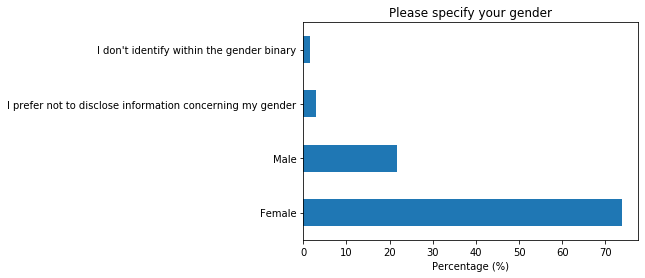

In [66]:
plotResp(survey['gender'],questions,normalize=True) # using helper function

### Age

25 - 65     71.014493
Over 65     15.942029
Under 25    13.043478
Name: age, dtype: float64


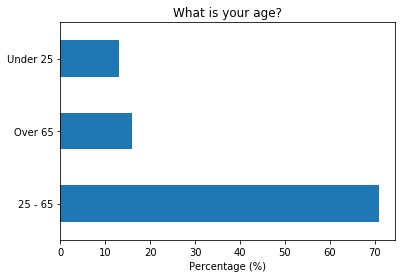

In [67]:
plotResp(survey['age'],questions,normalize=True)

### Family Status

Single no dependents         53.623188
Single with dependents       28.985507
Couple with dependents       10.144928
Other:                        4.347826
Couple without dependents     2.898551
Name: fam_status, dtype: float64


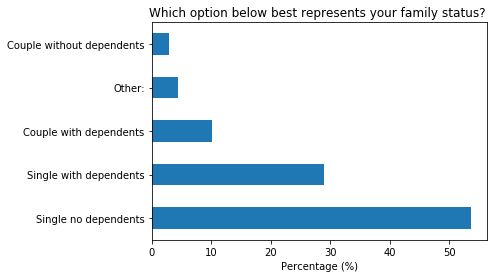

In [68]:
plotResp(survey['fam_status'],questions,normalize=True)

### Do you identify as First Nation (Status/Non-Status), Métis, or Inuk (Inuit)?

No                   82.608696
Yes                  10.144928
Prefer not to say     7.246377
Name: first_nation, dtype: float64


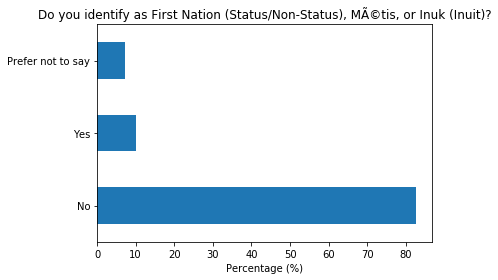

In [35]:
plotResp(survey['first_nation'],questions,normalize=True)

### Do you identify as a visible minority?

No                   84.057971
Yes                  10.144928
Prefer not to say     5.797101
Name: vis_minority, dtype: float64


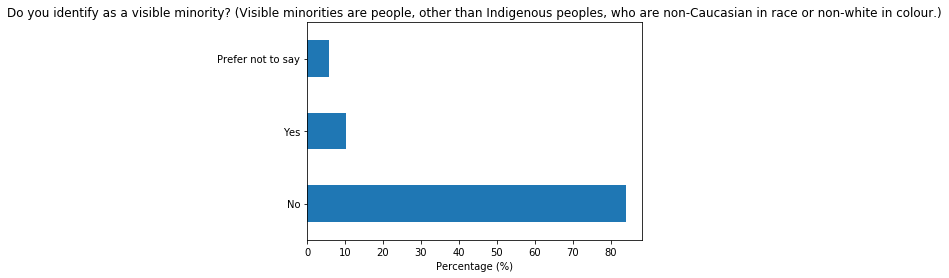

In [36]:
plotResp(survey['vis_minority'],questions,normalize=True)

### Residency Status

Canadian Citizen      94.202899
Other:                 4.347826
Permanent Resident     1.449275
Name: can_residency, dtype: float64


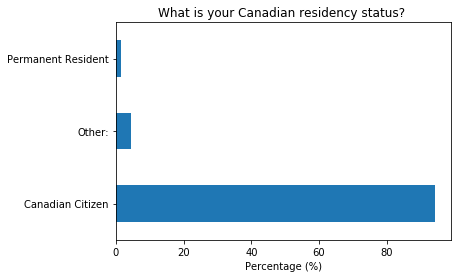

In [37]:
plotResp(survey['can_residency'],questions,normalize=True)

### Employment Status

Unemployed            44.927536
Retired               26.086957
Part time employed    14.492754
Student               10.144928
Full time employed     4.347826
Name: employment, dtype: float64


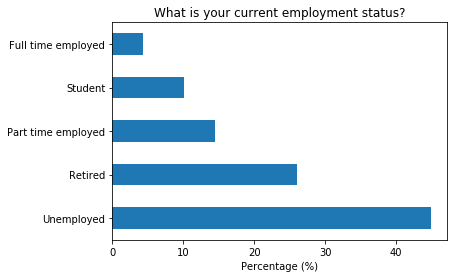

In [77]:
plotResp(survey['employment'],questions,normalize=True)

### Employment Status by age

age                   25 - 65  Over 65   Under 25
employment                                       
Full time employed   6.122449      NaN        NaN
Part time employed  18.367347      NaN  11.111111
Retired             14.285714    100.0        NaN
Student             10.204082      NaN  22.222222
Unemployed          51.020408      NaN  66.666667


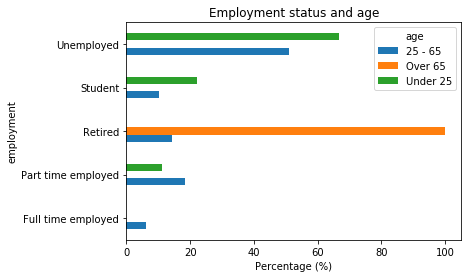

In [167]:
plotGroupBy(survey,'employment','age',title='Employment status and age',
                order=None,normalize=True)

### Current Living Status

I pay full market rent                                                     39.130435
I am staying with family and friends                                       27.536232
I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)                21.739130
Other (e.g., I am homeless, I live in an institution). Please describe:     8.695652
I am in an emergency shelter                                                1.449275
I own my home                                                               1.449275
Name: current_living_arr, dtype: float64


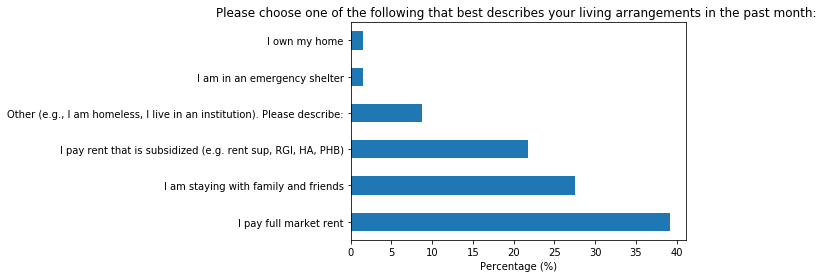

In [168]:
ax1 = plotResp(survey['current_living_arr'],questions,normalize=True)

### Reasons for moving

I can't afford where I live now                                            25.242718
It is only a temporary place to stay                                       23.300971
I need a larger place                                                      15.533981
I have concerns about the safety of my neighbourhood                       14.563107
My place is in need of repair                                               8.737864
I need to be closer to work childcare or social/health support services     5.825243
I need a modified unit because of disability. Please describe:              4.854369
I'm being evicted.                                                          1.941748
dtype: float64


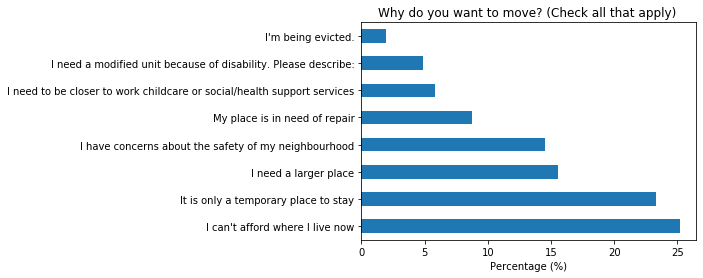

In [232]:
ax2 = plotResp(survey['why_move'],questions,normalize=True)

### Other variables by reason to move

In [233]:
# current living arrangement names
labels = ax1.get_yticklabels() # Get locations and labels
livingNames = [label.get_text() for label in labels]

# why move names
labels = ax2.get_yticklabels() # Get locations and labels
whyMoveNames = [label.get_text() for label in labels]

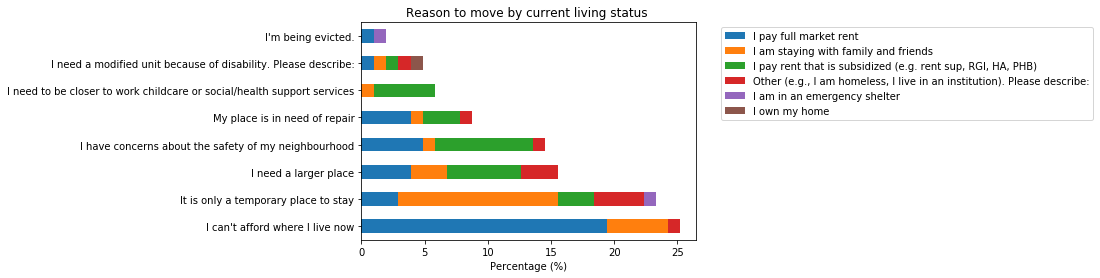

In [256]:
data = plotGroupByWhyMove(survey,'current_living_arr',whyMoveNames,livingNames,
                   title='Reason to move by current living status ',transpose=False)

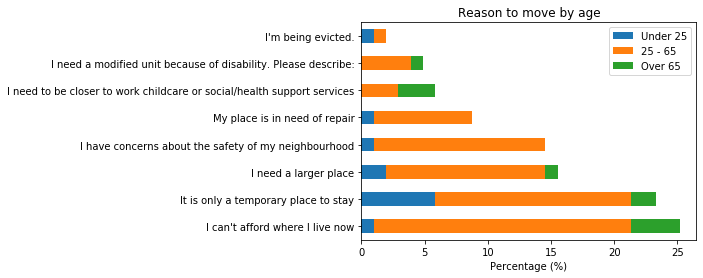

In [255]:
data = plotGroupByWhyMove(survey,'age',whyMoveNames,survey.age.dropna().unique().tolist(),
                   title='Reason to move by age',transpose=False,legendXLoc=1)

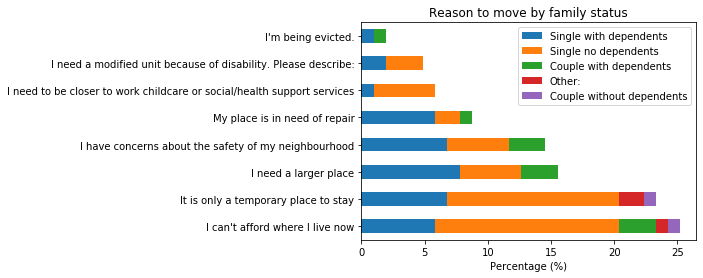

In [262]:
data = plotGroupByWhyMove(survey,'fam_status',whyMoveNames,survey.fam_status.dropna().unique().tolist(),
                   title='Reason to move by family status',transpose=False,legendXLoc=1)

In [280]:
def recodeMental(row):
    "Return a Pandas row object with modified mental health data"
    
    if (row.mental_health == 'A great deal') | (row.mental_health == 'A lot'):
        row.mental_health = 'Severe'
    elif (row.mental_health == 'A moderate amount') | (row.mental_health == 'A little'):
        row.mental_health = 'Moderate'
    elif row.mental_health == 'Not at all':
        row.mental_health = 'None'
    else:
        row.mental_health = row.mental_health
        
    return row.mental_health
            
survey['mod_mental'] = survey.apply(recodeMental,axis='columns')

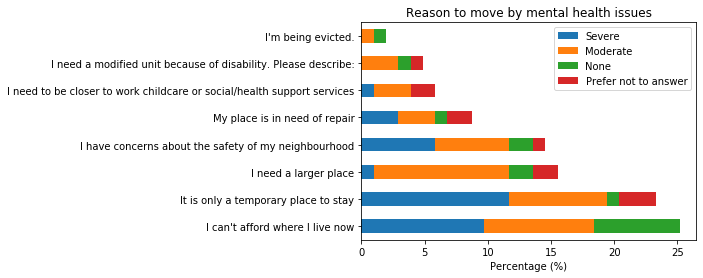

In [283]:
data = plotGroupByWhyMove(survey,'mod_mental',whyMoveNames,['Severe','Moderate','None','Prefer not to answer'],
                   title='Reason to move by mental health issues',transpose=False,legendXLoc=1)

## Waitlist Status

### Number of Times Applied for Waitlist status

4+    10.144928
3      7.246377
2     31.884058
1     50.724638
Name: num_applied, dtype: float64


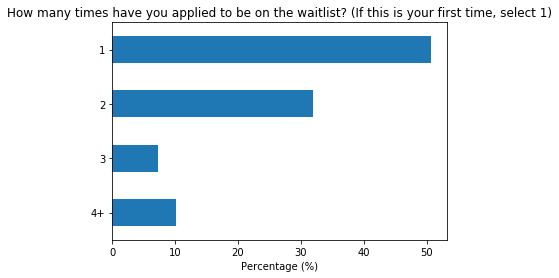

In [47]:
waitlistOrder = ['4+',3,2,1]
plotResp(survey['num_applied'],questions,order=waitlistOrder,normalize=True)

### Reason for applying multiple times

Other. Please describe:                                 58.823529
Missed annual check-in                                  29.411765
Became ineligible for the waitlist. Please describe:     8.823529
Missed annual check-in,Other. Please describe:           2.941176
Name: num_applied_explain, dtype: float64


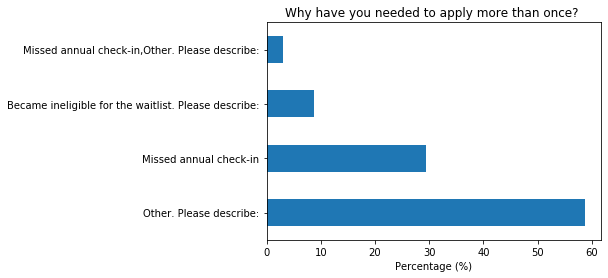

In [48]:
plotResp(survey['num_applied_explain'],questions,normalize=True)

### Applied to affordable housing options?

No              44.927536
I don't know    37.681159
Yes             17.391304
Name: private_housing, dtype: float64


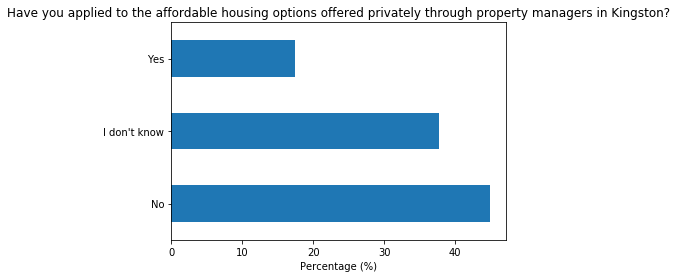

In [49]:
plotResp(survey['private_housing'],questions,normalize=True)

### Prefer to stay with rent subsidy

No     66.666667
Yes    33.333333
Name: subsidy, dtype: float64


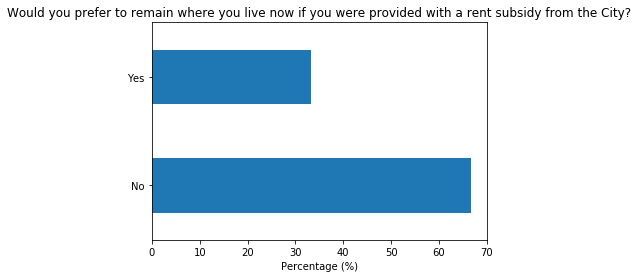

In [50]:
plotResp(survey['subsidy'],questions,normalize=True)

### Why do people want/not want the rent subsidy?

subsidy                                                    No        Yes
current_living_arr                                                      
I am in an emergency shelter                         2.173913        NaN
I am staying with family and friends                32.608696  17.391304
I own my home                                        2.173913        NaN
I pay full market rent                              30.434783  56.521739
I pay rent that is subsidized (e.g. rent sup, R...  21.739130  21.739130
Other (e.g., I am homeless, I live in an instit...  10.869565   4.347826


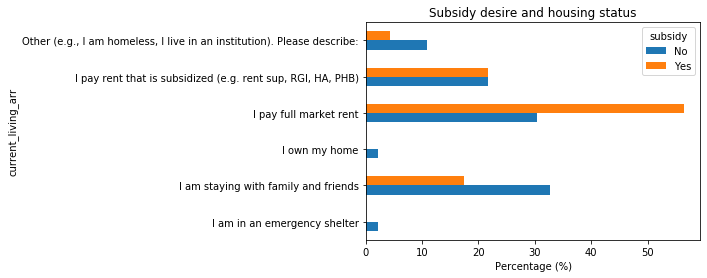

In [51]:
plotGroupBy(survey,'current_living_arr','subsidy',title='Subsidy desire and housing status',
                order=None,normalize=True)

I can't afford where I live now                                            46.875
It is only a temporary place to stay                                       15.625
I need a larger place                                                      15.625
I have concerns about the safety of my neighbourhood                        9.375
I need to be closer to work childcare or social/health support services     6.250
My place is in need of repair                                               6.250
dtype: float64


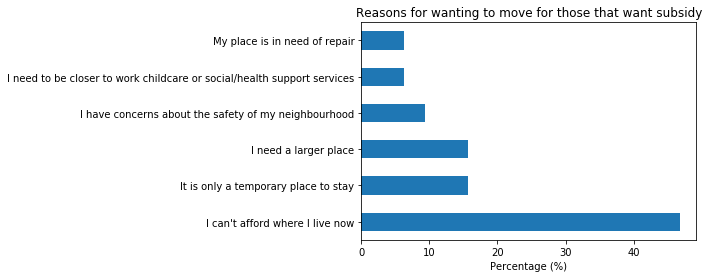

In [52]:
plotResp(survey.loc[(survey['subsidy']=='Yes')].why_move,questions,
         normalize=True,title='Reasons for wanting to move for those that want subsidy')

I can't afford where I live now                                   31.818182
I have concerns about the safety of my neighbourhood              18.181818
I need a larger place                                             13.636364
My place is in need of repair                                     13.636364
It is only a temporary place to stay                              13.636364
I need a modified unit because of disability. Please describe:     4.545455
I'm being evicted.                                                 4.545455
dtype: float64


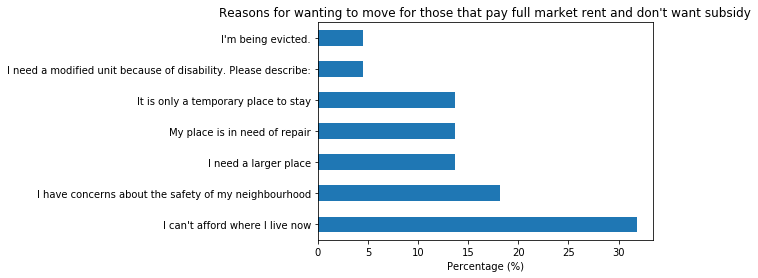

In [53]:
plotResp(survey.loc[(survey['subsidy']=='No') & 
    (survey['current_living_arr']=='I pay full market rent'
    )].why_move,questions,normalize=True,title='Reasons for wanting to move for those that pay full market rent'
    ' and don\'t want subsidy')

### How stable is your income?

Always Stable          49.275362
Frequently Stable      20.289855
Sometimes Unstable     13.043478
Frequently Unstable    10.144928
Always Unstable         7.246377
Name: income_stable, dtype: float64


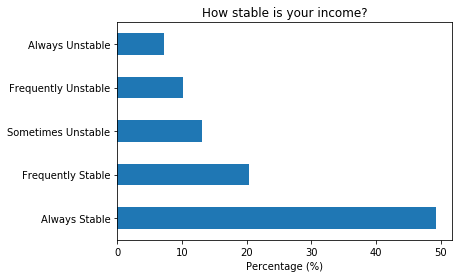

In [54]:
incomeOrder = ['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable']
plotResp(survey['income_stable'],questions,order=incomeOrder,normalize=True)

### Do you struggle to pay your utilities bill?

Always           8.955224
Frequently      13.432836
Sometimes       26.865672
Occasionally    14.925373
Never           35.820896
Name: utilities, dtype: float64


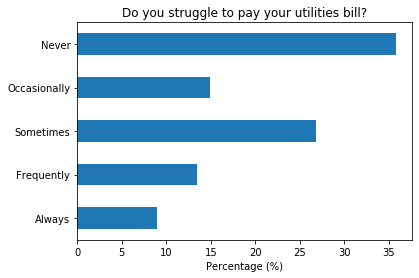

In [55]:
utilOrder = ['Always','Frequently','Sometimes','Occasionally','Never']
plotResp(survey['utilities'],questions,order=utilOrder,normalize=True)

### Is debt a reason why you are seeking a new residence?

Prefer not to answer     7.246377
A great deal            20.289855
A lot                   13.043478
A moderate amount       23.188406
A little                18.840580
Not at all              17.391304
Name: mental_health, dtype: float64


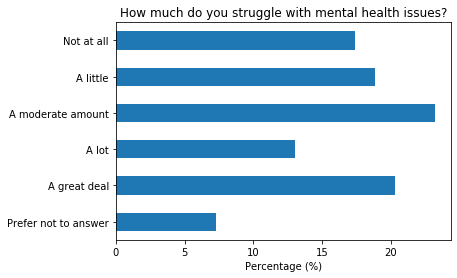

In [56]:
mentalOrder = ['Prefer not to answer','A great deal','A lot','A moderate amount',
              'A little','Not at all']
plotResp(survey['mental_health'],questions,order=mentalOrder,normalize=True)

### Mental health breakdown by gender

In [57]:
# Group by gender, convert to dataframe, and rename data col
data = survey.groupby(['gender']).mental_health.value_counts(normalize=True).reindex(mentalOrder,level='mental_health').to_frame(
).rename(columns={'mental_health':'resp'})
data.drop(index=["I don't identify within the gender binary",
                 "I prefer not to disclose information concerning my gender"],level='gender',inplace=True)

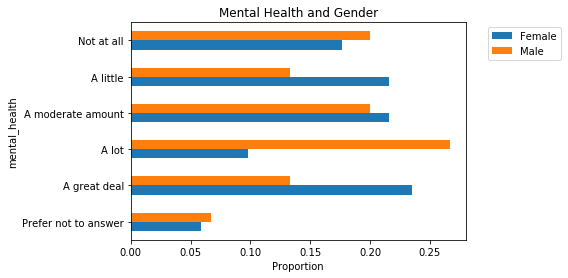

In [58]:
ax = pd.pivot_table(data, index = 'mental_health', columns = 'gender', 
    values = 'resp').plot(kind = 'barh',title='Mental Health and Gender')
plt.draw()
ax.set_xlabel('Proportion')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1)) # move legend to outside axes

### How much do you struggle with issues related to drinking or drug use?

Prefer not to answer     4.347826
A great deal             1.449275
A lot                         NaN
A moderate amount        4.347826
A little                10.144928
Not at all              79.710145
Name: substance_use, dtype: float64


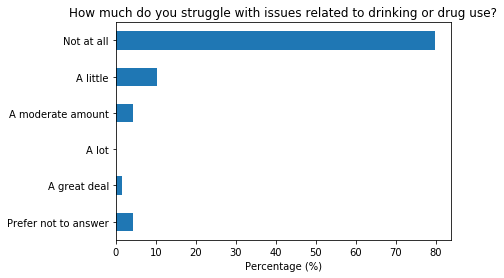

In [59]:
plotResp(survey['substance_use'],questions,order=mentalOrder,normalize=True)